# Work with SQL

For most tabularly structured data, such as spreadsheets or CSVs, we can fit them into a database that implements Structured Query Language, or SQL.

The Pandas `DataFrame` shares many similarities with SQL data tables in terms of functionalities, but it is bound to the application layer, which requires a properly configured Python runtime to function. On the other hand, SQL databases usually serve through their independent layer, thus not affected by application crashes on their own.

The Pandas library implements a set of interfaces to work with SQL databases (through an underlying abstraction library called `sqlalchemy`) to recognize the flexibility and strengths (such as better data persistence, among others) these databases can provide to work with data, especially for those that prefer a declarative language.

Among all the choices, SQLite is a fascinating one. It is a file-based SQL database solution with astonishing performance, near-zero configuration and maintenance, and comprehensive features. While it cannot compete with dedicated server-side SQL database solutions such as MySQL, Postgres, SQL Server, and others in a typical server/client application architecture, it excels at single-machine use cases. Usually, it performs faster than server-side solutions since there would be no network latency. It is widely available in UNIX/Linux-based systems due to its tiny footprints, such as iOS and Android.

Since we don't have to worry about database configurations, it's perfect for quick demonstrations and ad-hoc data persistence.

## Filter data

Recall the first recipe from [`locussdk-collab`](https://github.com/EQWorks/locussdk-collab):

In [1]:
# recipe from locussdk-collab
from locussdk import get_avail_poi_lists
from pandas import DataFrame


def search_avail_poi_lists(name: str = '', **kwargs) -> DataFrame:
    '''Search available POI lists based on locussdk.get_avail_poi_lists().

    Args:
        name (str): name to search in the available POI lists.
        **kwargs:
            All locussdk.get_avail_poi_lists() supported arguments.
            All pandas.Series.str.contains() supported arguments.

    Returns:
        pandas.DataFrame that contain the search resulting POI lists.

    Examples:
    >>> search_avail_poi_lists('pizza')
                name  poi_list_id whitelabelid customerid
    67       Bostonpizza           71         None       None
    113       Pizzapizza          118         None       None
    116       Pizzaville          121         None       None
    117     Pizzadelight          122         None       None
    139        Pizzanova          144         None       None
    157         Pizzahut          162         None       None
    175  Neworleanspizza          180         None       None
    327         241Pizza          332         None       None
    422       Royalpizza          427         None       None
    450       Ginospizza          455         None       None
    730     Mammas Pizza          735         None       None
    786      Doublepizza          791         None       None
    '''
    # build parameters we want to pass into get_avail_poi_lists()
    params = {'list_type': 'global'}  # default search in global
    for k in ['list_type', 'whitelabel', 'customer']:
        if v := kwargs.pop(k, None):
            params[k] = v

    lists = get_avail_poi_lists(**params)

    # return the full available POI lists if no search string given
    if not name:
        return lists

    return lists[lists['name'].str.contains(name, **kwargs)]

In [2]:
search_avail_poi_lists(name='pizza', case=False).reset_index(drop=True)

,name,poi_list_id,whitelabelid,customerid
0,Bostonpizza,71,None,None
1,Pizzapizza,118,None,None
2,Pizzaville,121,None,None
3,Pizzadelight,122,None,None
4,Pizzanova,144,None,None
5,Pizzahut,162,None,None
6,Neworleanspizza,180,None,None
7,241Pizza,332,None,None
8,Royalpizza,427,None,None
9,Ginospizza,455,None,None


We can easily recreate this using the SQL `WHERE` syntax.

First, let's load all global POI lists into a SQLite data table:

In [3]:
all_lists = get_avail_poi_lists('global')
all_lists

,name,poi_list_id,whitelabelid,customerid
0,Second Cup Canada,2,None,None
1,McDonalds,3,None,None
2,Tim Hortons,4,None,None
3,Xtracash,7,None,None
4,Overwaiteafoods,8,None,None
...,...,...,...,...
837,WMG - Subway,845,None,None
838,5Buds Cannabis,1431,None,None
839,BC Medi Chronic,1432,None,None
840,Beleave,1435,None,None


Since SQLite is so omnipresent, Python even has this as a part of its standard built-in library:

In [4]:
# SQLite is so omnipresent that Python has this as a part of its standard built-in library
import sqlite3 as sql

In [5]:
# write it into the DB table `poi_lists`
with sql.connect('global_poi_lists.db') as con:
    all_lists.to_sql('poi_lists', con=con, if_exists='replace', index=False)

Now let's query the database table we populated just now with the same search condition as the recipe version does through a simple SQL query:

```sql
SELECT *
FROM poi_lists
WHERE name LIKE '%pizza%';
```

In [6]:
import pandas as pd

with sql.connect('global_poi_lists.db') as con:
    # read it out
    pizzas_db = pd.read_sql(
        sql='''
            SELECT *
            FROM poi_lists
            WHERE name LIKE '%pizza%';
        ''',
        con=con,
    )

pizzas_db

,name,poi_list_id,whitelabelid,customerid
0,Bostonpizza,71,None,None
1,Pizzapizza,118,None,None
2,Pizzaville,121,None,None
3,Pizzadelight,122,None,None
4,Pizzanova,144,None,None
5,Pizzahut,162,None,None
6,Neworleanspizza,180,None,None
7,241Pizza,332,None,None
8,Royalpizza,427,None,None
9,Ginospizza,455,None,None


## Aggregation

For `DataFrame`s that carry the same columns, we can simply append them all into the same table.

For instance, we can populate a `pois` table with all POIs that has a name related to "pizza":

In [7]:
import locussdk as locus

# load POIs into a DB
with sql.connect('global_poi_lists.db') as con:
    pizza_ids = pd.read_sql(
        sql='''
            SELECT poi_list_id
            FROM poi_lists
            WHERE name LIKE '%pizza%';
        ''',
        con=con,
    ).poi_list_id

    for list_id in pizza_ids:
        locus.get_pois(list_id).to_sql(
            'pois',
            if_exists='append',
            con=con,
            index=False,
        )

Quick verifications using a filter on all `region = ON`:

In [8]:
# filter by region == 'ON', like in 09
with sql.connect('global_poi_lists.db') as con:
    pizzas_on = pd.read_sql(
        sql='''
            SELECT *
            FROM pois
            WHERE region = 'ON';
        ''',
        con=con,
    )

pizzas_on

,id,name,city,region,postalCode,country,addressLabel,lat,lon,coords,chainId
0,32943,Bostonpizza - Conroy,Ottawa,ON,K1G 6C1,CA,"2980 Conroy Road,Ottawa,ON,K1G 6C1, Canada",45.382767,-75.630243,"45.3827671, -75.6302429",70
1,32944,Bostonpizza - St Laurent,Ottawa,ON,K1K 3B1,CA,"1055 St. Laurent Blvd.,Ottawa,ON,K1K 3B1, Canada",45.427042,-75.638414,"45.4270421, -75.638414",70
2,32945,Bostonpizza - Orleans,Orleans,ON,K1W 1K9,CA,"3884 Innes Road,Orleans,ON,K1W 1K9, Canada",45.453038,-75.510222,"45.4530377, -75.5102222",70
3,32946,Bostonpizza - Carling,Ottawa,ON,K2A 1C5,CA,"1640 Carling Avenue,Ottawa,ON,K2A 1C5, Canada",45.379562,-75.748339,"45.3795624, -75.7483389",70
4,32947,Bostonpizza - Hunt Club,Nepean,ON,K2G 5W5,CA,"521 West Hunt Club Road,Nepean,ON,K2G 5W5, Canada",45.334702,-75.725216,"45.3347017, -75.7252156",70
...,...,...,...,...,...,...,...,...,...,...,...
992,109512,Mammaspizza,Toronto,ON,M5C 1W4,CA,"127 Yonge St,Toronto,ON,M5C 1W4, Canada",43.650915,-79.378494,"43.6509148, -79.3784936",734
993,109513,Mammaspizza,Toronto,ON,M5J 2N5,CA,"249 Queens Quay W,Toronto,ON,M5J 2N5, Canada",43.638775,-79.386187,"43.6387748, -79.3861871",734
994,109514,Mammaspizza,Toronto,ON,M5V 1X3,CA,"405 Richmond Street West,Toronto,ON,M5V 1X3, C...",43.647775,-79.395362,"43.6477754, -79.395362",734
995,109515,Mammaspizza,Toronto,ON,M6C 2C5,CA,"944 Eglinton W,Toronto,ON,M6C 2C5, Canada",43.700560,-79.428610,"43.7005602, -79.4286096",734


Or see a total count of POIs:

In [9]:
with sql.connect('global_poi_lists.db') as con:
    print(con.execute('SELECT COUNT(*) FROM pois;').fetchone()[0])

1602


We can also aggregate the sum of shops through `GROUP BY`:

In [10]:
# get some aggregated stats using SQL
with sql.connect('global_poi_lists.db') as con:
    # number of shops by chain and by city + region
    by_city_chain = pd.read_sql(
        sql='''
            SELECT chainid, city, region, name, count(*) AS shops
            FROM pois
            GROUP BY chainid, city, region;
        ''',
        con=con,
    )
    # by chain and region
    by_region_chain = pd.read_sql(
        sql='''
            SELECT chainid, region, name, count(*) AS shops
            FROM pois
            GROUP BY chainid, region;
        ''',
        con=con,
    )
    # by chain
    by_chain = pd.read_sql(
        sql='''
            SELECT chainid, name, count(*) AS shops
            FROM pois
            GROUP BY chainid;
        ''',
        con=con,
    )

In [11]:
by_city_chain

,chainId,city,region,name,shops
0,70,Abbotsford,BC,Bostonpizza - Abbotsford,2
1,70,Airdrie,AB,Bostonpizza - Airdrie,1
2,70,Ajax,ON,Bostonpizza - Ajax,1
3,70,Aldergrove,BC,Bostonpizza - Aldergrove,1
4,70,Alliston,ON,Bostonpizza - Alliston,1
...,...,...,...,...,...
836,790,Longueuil,QC,Doublepizza,1
837,790,Montreal,QC,Doublepizza,18
838,790,R.D.P,QC,Doublepizza,1
839,790,Saint-Eustache,QC,Doublepizza,1


Looks like "Bostonpizza" cases come with a range of varieties, and if we want to normalize it to its uniform brand name, SQLite lacks a simple way to do it. Fortunately, this is where we can use `DataFrame`'s string manipulation interface to solve it:

In [12]:
# some extra manipulation
by_city_chain['name'] = by_city_chain['name'].str.replace(' - .*', '')
by_city_chain

,chainId,city,region,name,shops
0,70,Abbotsford,BC,Bostonpizza,2
1,70,Airdrie,AB,Bostonpizza,1
2,70,Ajax,ON,Bostonpizza,1
3,70,Aldergrove,BC,Bostonpizza,1
4,70,Alliston,ON,Bostonpizza,1
...,...,...,...,...,...
836,790,Longueuil,QC,Doublepizza,1
837,790,Montreal,QC,Doublepizza,18
838,790,R.D.P,QC,Doublepizza,1
839,790,Saint-Eustache,QC,Doublepizza,1


In [13]:
by_region_chain['name'] = by_region_chain['name'].str.replace(' - .*', '')
by_region_chain

,chainId,region,name,shops
0,70,AB,Bostonpizza,106
1,70,BC,Bostonpizza,60
2,70,MB,Bostonpizza,18
3,70,NB,Bostonpizza,5
4,70,NL,Bostonpizza,3
5,70,NS,Bostonpizza,11
6,70,NT,Bostonpizza,1
7,70,ON,Bostonpizza,116
8,70,PE,Bostonpizza,1
9,70,QC,Bostonpizza,28


In [14]:
by_chain['name'] = by_chain['name'].str.replace(' - .*', '')
by_chain

,chainId,name,shops
0,70,Bostonpizza,372
1,117,Pizzapizza,389
2,120,Pizzaville,69
3,121,Pizzadelight,77
4,143,Pizzanova,128
5,161,Pizzahut,329
6,179,Neworleanspizza,39
7,331,241Pizza,70
8,426,Royalpizza,7
9,454,Ginospizza,80


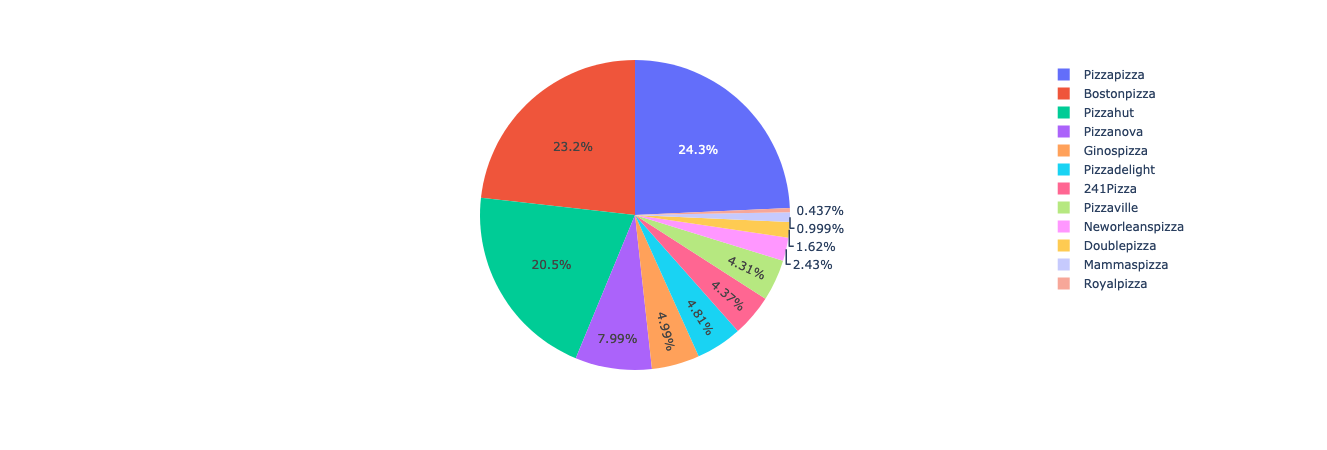

In [16]:
# some quick visualization
import plotly.express as px

px.pie(by_chain, values='shops', names='name')

For regional/provincial pie charts, let's add some interactivity through `ipywidgets` from the [last session](10-bridging-web-ui-to-notebook.ipynb):

In [25]:
import ipywidgets as widgets

regions = by_region_chain.region.unique().tolist()

def regional_pie(index):
    fig = px.pie(by_region_chain[by_region_chain['region'] == index], values='shops', names='name')

    return fig.show()


t = widgets.interact(
    regional_pie,
    index=widgets.ToggleButtons(
        options=regions,
        description='Province',
    ),
)

interactive(children=(ToggleButtons(description='Province', options=('AB', 'BC', 'MB', 'NB', 'NL', 'NS', 'NT',…

## Remarks

Whether it's for preference flexibility and practical measures, adding a SQL solution to our toolbelt of data analysis is never a bad idea.

## References

* SQLite [official website](https://sqlite.org/index.html)
* [Python `sqlite3` module documentation](https://docs.python.org/3/library/sqlite3.html)
* Pandas' own [comparison with SQL](https://pandas.pydata.org/pandas-docs/stable/getting_started/comparison/comparison_with_sql.html), and the documentation on its `read_sql()` and `DataFrame/Series.to_sql()` interfaces.